<a href="https://colab.research.google.com/github/NikhilSharma2707/Alzheimers-Detection-Using-Deep-Learning-Techniques/blob/master/CNN_Sequential_Alzheimers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'imagesoasis:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3419493%2F5962731%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240424%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240424T090955Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1b13f5513ec4cc22f6784069569fd7eadd60095903b58e4c7ec537eff4f665457af8ed905c6b26275166d92a1670eaec35d6565bd25aca19cee74f21a3da0922dede27e87a364e5a8dad66c912dfca59d04c6ed0fe56337720443f58685e5d600f9b1bd77bdca8b8caf6f005dd38e8daa055d0c59ba5452f28766028530634cafc5f0fe10eb46d9dffe279f3035346f0981bfa501f574726478c8f48175caaa982dcec4f26181be5ead0bc9cc6d13eb1c61faa970730cb82baed7b93c29d41be7fb8351624c8ef1fdd8b476765aa62c0317e42a4703bcb195f675130e9a0742f3b993d291380708aee9314d55dadbc0bf2d56183a9f75126bdaa6d121346bac7'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1322017985 bytes downloaded
Downloaded and uncompressed: imagesoasis
Data source import complete.


In [ ]:

import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import re
import os
import random
import tensorflow as tf
import plotly.express as px

from keras.models import Sequential
from PIL import Image
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, average_precision_score, confusion_matrix, roc_auc_score, f1_score, confusion_matrix, precision_recall_fscore_support
from tensorflow.keras.applications import EfficientNetB0, EfficientNetV2B1
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import clone_model
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from PIL import Image
from scipy.stats import skew
from tqdm import tqdm

In [ ]:
non_demented = []
very_mild_demented = []
mild_demented = []
moderate_demented = []


for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Non Demented'):
    for filename in filenames:
        non_demented.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Very mild Dementia'):
    for filename in filenames:
        very_mild_demented.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Mild Dementia'):
    for filename in filenames:
        mild_demented.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Moderate Dementia'):
    for filename in filenames:
        moderate_demented.append(os.path.join(dirname, filename))

In [ ]:
print(len(non_demented))
print(len(very_mild_demented))
print(len(mild_demented))
print(len(moderate_demented))

67222
13725
5002
488


In [ ]:
def get_info_from_filename(filename):
    pattern = re.compile('OAS1_(\d+)_MR(\d+)_mpr-(\d+)_(\d+).jpg')
    match = pattern.match(filename)
    patient_id = match.group(1)
    mr_id = match.group(2)
    scan_id = match.group(3)
    layer_id = match.group(4)

    return patient_id, mr_id, scan_id, layer_id

In [ ]:
def create_ref_df(dataset_path):
    paths, labels = [], []
    patient_ids, mr_ids, scan_ids, layer_ids = [], [], [], []


    for folder in os.listdir(dataset_path):


        for file in os.listdir(os.path.join(dataset_path, folder)):


            patient_id, mr_id, scan_id, layer_id = get_info_from_filename(file)


            paths.append(os.path.join(dataset_path, folder, file))
            labels.append(folder)
            patient_ids.append(patient_id)
            mr_ids.append(mr_id)
            scan_ids.append(scan_id)
            layer_ids.append(layer_id)


    ref_df = pd.DataFrame({
        'path': paths,
        'label': labels,
        'patient_id': patient_ids,
        'mr_id': mr_ids,
        'scan_id': scan_ids,
        'layer_id': layer_ids
    })


    ref_df = ref_df.astype({
        'path': 'string',
        'label': 'string',
        'patient_id': 'int64',
        'mr_id': 'int64',
        'scan_id': 'int64',
        'layer_id': 'int64'
    })

    return ref_df

In [ ]:
ref_df = create_ref_df('/kaggle/input/imagesoasis/Data')

In [ ]:
def load_labels_and_paths(ref_df):
    labels = []
    paths = []


    for idx, row in tqdm(ref_df.iterrows(), total=ref_df.shape[0]):


        labels.append(row['label'])
        paths.append(row['path'])


    return labels, paths

In [ ]:
labels, paths = load_labels_and_paths(ref_df)

100%|██████████| 86437/86437 [00:05<00:00, 16917.90it/s]


In [ ]:
def get_image_stats(images, labels, paths):
    means, stds, widths, heights = [], [], [], []
    skewnesses = []


    for image in tqdm(images):


        means.append(np.mean(image))
        stds.append(np.std(image))


        widths.append(image.shape[0])
        heights.append(image.shape[1])


        image_hist = np.histogram(image.flatten())[0]
        skewnesses.append(skew(image_hist))


    image_stats = pd.DataFrame({
        'mean': means,
        'std': stds,
        'width': widths,
        'height': heights,
        'skew': skewnesses
    })


    image_stats['label'] = labels
    image_stats['path'] = paths

    return image_stats

In [ ]:
frequencies = [len(non_demented),  len(very_mild_demented), len(moderate_demented), len(mild_demented),]
class_names = ["non_demented", "very_mild_demented", "moderate_demented", "mild_demented"]


sorted_indices = np.argsort(frequencies)[::-1]
class_names = np.array(class_names)[sorted_indices]
frequencies = np.array(frequencies)[sorted_indices]

In [ ]:
random.seed(42)


# Split off a test set for the moderate_demented class
moderate_demented_train, moderate_demented_test = train_test_split(
    moderate_demented, test_size=0.20, random_state=42
)

# Split off a test set for the mild_demented class
mild_demented_train, mild_demented_test = train_test_split(
    mild_demented, test_size=0.20, random_state=42
)

# Split off a test set for the very_mild_demented class
very_mild_demented_train, very_mild_demented_test = train_test_split(
    very_mild_demented, test_size=0.20, random_state=42
)

# Split off a test set for the non_demented class
non_demented_train, non_demented_test = train_test_split(
    non_demented, test_size=0.20, random_state=42
)

In [ ]:
print(len(non_demented_train))
print(len(very_mild_demented_train))
print(len(mild_demented_train))
print(len(moderate_demented_train))

53777
10980
4001
390


In [ ]:
target_samples = 5000

# Oversample small classes
moderate_demented_samp = random.choices(moderate_demented_train, k=target_samples)
mild_demented_samp = random.choices(mild_demented_train, k=target_samples)

# Undersample large classes
very_mild_demented_samp = random.sample(very_mild_demented_train, k=target_samples)
non_demented_samp = random.sample(non_demented_train, k=target_samples)

In [ ]:
print(len(non_demented_samp))
print(len(very_mild_demented_samp))
print(len(mild_demented_samp))
print(len(moderate_demented_samp))

5000
5000
5000
5000


In [ ]:
print(len(non_demented_test))
print(len(very_mild_demented_test))
print(len(mild_demented_test))
print(len(moderate_demented_test))

13445
2745
1001
98


In [ ]:
target_samples = 640

# Undersample large classes
mild_demented_test = random.sample(mild_demented_test, k=target_samples)
very_mild_demented_test = random.sample(very_mild_demented_test, k=target_samples)
non_demented_test = random.sample(non_demented_test, k=target_samples)

In [ ]:
encoder = OneHotEncoder()
encoder.fit([[0],[1],[2],[3]])

OneHotEncoder()

In [ ]:
data = []
result = []

# Loop through each category and transform data and result into right format (128x128x3 & one-hot encoded)
# and merge categories together
for path in non_demented_samp:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())

for path in very_mild_demented_samp:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())
for path in mild_demented_samp:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[2]]).toarray())

for path in moderate_demented_samp:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[3]]).toarray())

In [ ]:
data = np.array(data)


data.shape

(20000, 128, 128, 3)

In [ ]:
result = np.array(result)


result = result.reshape((data.shape[0],4))


result.shape

(20000, 4)

In [ ]:
x_train,x_val,y_train,y_val = train_test_split(data,result, test_size=0.20, shuffle=True, random_state=42)

In [ ]:
data_test = []
result_test = []

for path in non_demented_test:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data_test.append(np.array(img))
        result_test.append(encoder.transform([[0]]).toarray())

for path in very_mild_demented_test:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data_test.append(np.array(img))
        result_test.append(encoder.transform([[1]]).toarray())

for path in mild_demented_test:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data_test.append(np.array(img))
        result_test.append(encoder.transform([[2]]).toarray())

for path in moderate_demented_test:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data_test.append(np.array(img))
        result_test.append(encoder.transform([[3]]).toarray())


In [ ]:
data_test = np.array(data_test)
data_test.shape

(2018, 128, 128, 3)

In [ ]:
result_test = np.array(result_test)
result_test = result_test.reshape((data_test.shape[0],4))
result_test.shape

(2018, 4)

In [ ]:
x_test = data_test
y_test = result_test


In [ ]:
y_train_int = np.argmax(y_train, axis=1)
y_val_int = np.argmax(y_val, axis=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

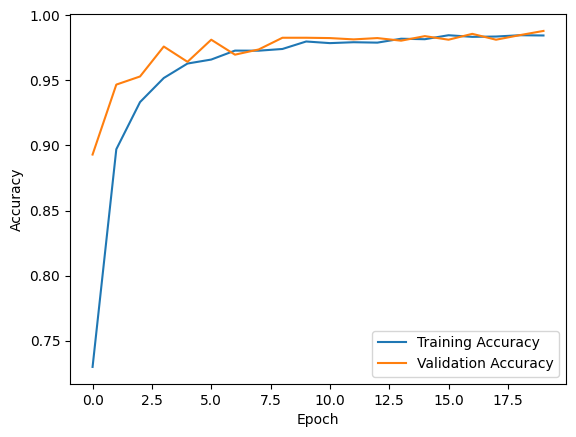

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))  # Output layer with 4 units for 4 classes

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.summary()


history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_val, y_val))

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history = model.fit(x_train, y_train_int, epochs=10, batch_size=16,
                    verbose=1, validation_data=(x_val, y_val_int))

Epoch 1/10
1000/1000 [==============================] - 16s 13ms/step - loss: 0.0806 - accuracy: 0.9775 - val_loss: 0.0593 - val_accuracy: 0.9872
Epoch 2/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.0708 - accuracy: 0.9793 - val_loss: 0.0550 - val_accuracy: 0.9880
Epoch 3/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.0522 - accuracy: 0.9847 - val_loss: 0.0674 - val_accuracy: 0.9850
Epoch 4/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.0652 - accuracy: 0.9819 - val_loss: 0.0557 - val_accuracy: 0.9835
Epoch 5/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.0570 - accuracy: 0.9843 - val_loss: 0.0775 - val_accuracy: 0.9843
Epoch 6/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.0500 - accuracy: 0.9855 - val_loss: 0.0809 - val_accuracy: 0.9855
Epoch 7/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.0459 - accuracy: 0.9862 - val_loss: 0.0414 -

In [ ]:
y_test_int = np.argmax(y_test, axis=1)

In [ ]:
testeval = model.evaluate(x_test, y_test_int, verbose=2)

print("Test Loss:", testeval[0])
print("Test Accuracy:", testeval[1])

64/64 - 0s - loss: 0.0940 - accuracy: 0.9851 - 408ms/epoch - 6ms/step
Test Loss: 0.09400506317615509
Test Accuracy: 0.9851337671279907


In [ ]:
y_pred_int = np.argmax(model.predict(x_test), axis=1)


64/64 [==============================] - 0s 5ms/step


In [ ]:
y_pred_one_hot = to_categorical(y_pred_int, num_classes=4)

# True labels one hot encoded: y_test

# True labels integers: y_test_int

# Calculate precision, recall, and F1 score per class --> uses integers
precision, recall, f1, _ = precision_recall_fscore_support(y_test_int, y_pred_int, average=None)

# Print precision, recall, and F1 score for each class
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f'Class {i}: Precision = {p:.4f}, Recall = {r:.4f}, F1 Score = {f:.4f}')

# Calculate micro-averages --> uses one hot encoded labels
micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(y_test, y_pred_one_hot, average='micro')

# Print precision, recall and F1 score micro average
print("Micro-average Precision:", round(micro_precision, 4))
print("Micro-average Recall:", round(micro_recall, 4))
print("Micro-average F1 Score:", round(micro_f1, 4))

Class 0: Precision = 0.9952, Recall = 0.9641, F1 Score = 0.9794
Class 1: Precision = 0.9665, Recall = 0.9922, F1 Score = 0.9792
Class 2: Precision = 0.9922, Recall = 0.9969, F1 Score = 0.9945
Class 3: Precision = 1.0000, Recall = 1.0000, F1 Score = 1.0000
Micro-average Precision: 0.9851
Micro-average Recall: 0.9851
Micro-average F1 Score: 0.9851


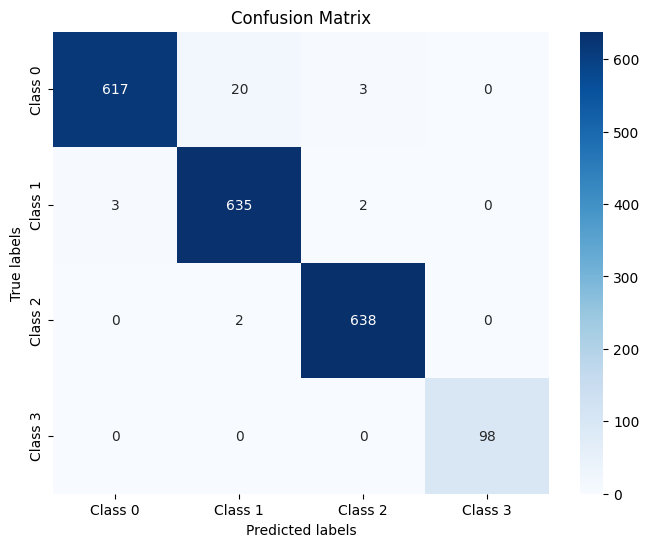

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


conf_matrix = confusion_matrix(y_test_int, y_pred_int)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"],
            yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model.save("Alzheimers_Detection_cnn_sequential.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf

# Load the saved model
loaded_model = tf.keras.models.load_model('/content/Alzheimers_Detection_cnn_sequential.h5')

In [ ]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


model.fit(x_train, y_train)


y_pred = model.predict(x_val)


accuracy = accuracy_score(y_val, y_pred)

print("Accuracy:", accuracy)


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy
        return backend.sparse_categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy
        res = tf.nn.sparse_softmax_cross_entropy_with_logits(

    ValueError: `labels.shape` must equal `logits.shape` except for the last dimension. Received: labels.shape=(128,) and logits.shape=(32, 4)
